In [1]:
!pip install -q xgboost scikit-learn pandas numpy matplotlib seaborn joblib

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (mean_squared_error, r2_score,
                             accuracy_score, confusion_matrix,
                             classification_report)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
import random
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [5]:
def generate_employee_ids(num_employees=50):
    return [f'E{str(i).zfill(3)}' for i in range(1, num_employees+1)]

def generate_tasks_data(employee_ids, num_weeks=12):
    task_categories = ['Documentation', 'Coding', 'Meeting', 'Research', 'Planning', 'Review']
    priorities = ['Low', 'Medium', 'High']
    times_of_day = ['Morning', 'Afternoon', 'Evening']
    completion_statuses = ['Completed', 'Partially Completed', 'Not Started']

    tasks = []
    task_id = 1

    task_options = [
        "Complete weekly team progress report",
        "Schedule one-on-one meetings",
        "Review backlog items",
        "Prepare stakeholder presentation",
        "Update project documentation"
    ]

    for week in range(1, num_weeks+1):
        for emp_id in employee_ids:
            num_tasks = random.randint(5, 15)
            for _ in range(num_tasks):
                task_name = random.choice(task_options)
                tasks.append([
                    f'T{task_id}', emp_id, task_name, random.choice(task_categories),
                    round(random.uniform(0.5, 8.0), 2),
                    round(random.uniform(0.5, 8.0) * random.uniform(0.7, 1.5), 2),
                    random.choice(priorities),
                    random.choice(times_of_day),
                    random.choices(completion_statuses, weights=[0.7, 0.2, 0.1])[0],
                    week
                ])
                task_id += 1

    return pd.DataFrame(tasks, columns=[
        'task_id', 'employee_id', 'task_name', 'category',
        'estimated_time', 'actual_time', 'priority',
        'time_of_day', 'completion_status', 'week_id'
    ])

def generate_behavior_logs(employee_ids, num_weeks=12):
    behavior_logs = []
    for week in range(1, num_weeks+1):
        for emp_id in employee_ids:
            behavior_logs.append([
                emp_id, week,
                round(random.uniform(200, 400), 2),
                random.randint(2, 8),
                random.randint(10, 30),
                round(random.uniform(5, 15), 2),
                random.choice(['Low', 'Medium', 'High']),
                random.randint(1, 5),
                random.choice(['Dim', 'Moderate', 'Bright'])
            ])
    return pd.DataFrame(behavior_logs, columns=[
        'employee_id', 'week_id', 'screen_time_minutes', 'breaks_taken',
        'context_switches', 'meeting_hours', 'noise_level',
        'collaboration_sessions', 'light_environment'
    ])

def generate_weekly_summary(tasks_df, behavior_df):
    weekly_data = []
    for (emp_id, week), group in tasks_df.groupby(['employee_id', 'week_id']):
        completed = group[group['completion_status'] == 'Completed'].shape[0]
        total = group.shape[0]
        completion_rate = completed / total if total > 0 else 0
        time_diff = (group['actual_time'] - group['estimated_time']).mean()

        behavior = behavior_df[(behavior_df['employee_id'] == emp_id) &
                             (behavior_df['week_id'] == week)].iloc[0]

        base_score = 70 + (completion_rate * 20) - (abs(time_diff) * 5) + \
                   (behavior['breaks_taken'] * 0.5) - (behavior['context_switches'] * 0.3) - \
                   (behavior['meeting_hours'] * 0.7) + (behavior['collaboration_sessions'] * 1.2)

        efficiency_score = min(100, max(0, round(base_score * random.uniform(0.95, 1.05), 2)))

        if efficiency_score >= 80:
            label = 'Highly Effective'
        elif efficiency_score >= 50:
            label = 'Average'
        else:
            label = 'At Risk'

        weekly_data.append([
            emp_id, week, completed, round(time_diff, 2),
            behavior['screen_time_minutes'], behavior['context_switches'],
            behavior['breaks_taken'], label, efficiency_score
        ])

    return pd.DataFrame(weekly_data, columns=[
        'employee_id', 'week_id', 'tasks_completed', 'average_task_duration',
        'screen_time_total', 'context_switch_total', 'breaks_total',
        'productivity_label', 'efficiency_score'
    ])

# Generate data
employee_ids = generate_employee_ids()
tasks_df = generate_tasks_data(employee_ids)
behavior_df = generate_behavior_logs(employee_ids)
weekly_df = generate_weekly_summary(tasks_df, behavior_df)

In [6]:
def merge_datasets(tasks_df, behavior_df, weekly_df):
    task_agg = tasks_df.groupby(['employee_id', 'week_id']).agg({
        'estimated_time': ['mean', 'sum'],
        'actual_time': ['mean', 'sum'],
        'completion_status': lambda x: (x == 'Completed').mean(),
        'priority': lambda x: (x == 'High').mean(),
        'time_of_day': lambda x: (x == 'Morning').mean(),
        'category': lambda x: x.nunique()
    })
    task_agg.columns = [
        'avg_estimated_time', 'total_estimated_time',
        'avg_actual_time', 'total_actual_time',
        'completion_rate', 'high_priority_ratio',
        'morning_task_ratio', 'unique_categories'
    ]
    task_agg = task_agg.reset_index()

    merged_df = pd.merge(task_agg, behavior_df, on=['employee_id', 'week_id'])
    return pd.merge(merged_df, weekly_df[['employee_id', 'week_id', 'productivity_label', 'efficiency_score']],
                   on=['employee_id', 'week_id'])

merged_df = merge_datasets(tasks_df, behavior_df, weekly_df)
X = merged_df.drop(['employee_id', 'week_id', 'productivity_label', 'efficiency_score'], axis=1)
y_reg = merged_df['efficiency_score']
y_clf = merged_df['productivity_label']

X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.2, random_state=42
)

# Preprocessing
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Regression Model
reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, max_depth=3, random_state=42))
])
reg_pipeline.fit(X_train, y_reg_train)

# Classification Model
clf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
clf_pipeline.fit(X_train, y_clf_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['avg_estimated_time', 'total_estimated_time', 'avg_actual_time',
       'total_actual_time', 'completion_rate', 'high_priority_ratio',
       'morning_task_ratio', 'unique_categories', 'screen_time_minutes',
       'breaks_taken', 'context_switches', 'meeting_hours',
       'collaboration_sessions'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['noise_level', 'light_environment'], dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

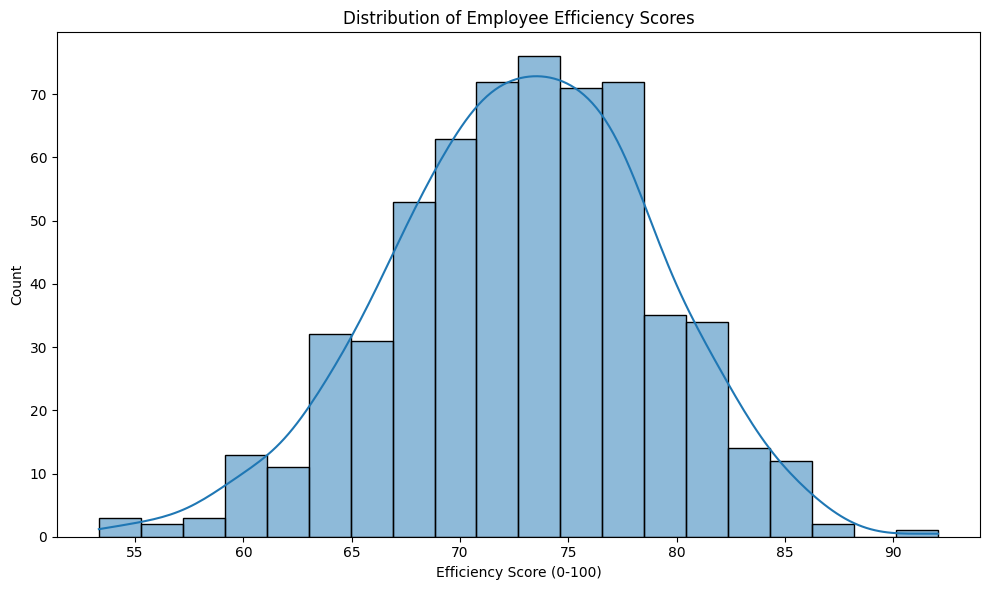

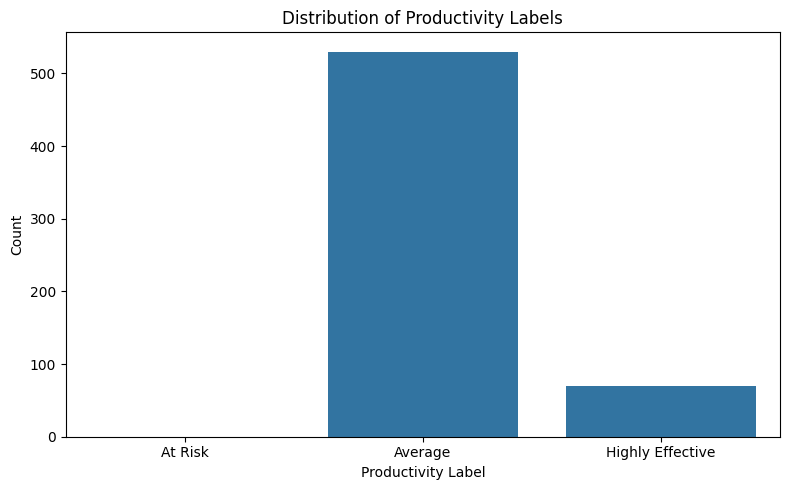

Correlation matrix:
                         week_id  tasks_completed  average_task_duration  \
week_id                1.000000        -0.039074              -0.019549   
tasks_completed       -0.039074         1.000000               0.008860   
average_task_duration -0.019549         0.008860               1.000000   
screen_time_total      0.028329         0.058341              -0.050034   
context_switch_total   0.019418        -0.018044               0.029010   
breaks_total          -0.054520        -0.032992               0.054181   
efficiency_score      -0.056088         0.321856              -0.277121   

                       screen_time_total  context_switch_total  breaks_total  \
week_id                         0.028329              0.019418     -0.054520   
tasks_completed                 0.058341             -0.018044     -0.032992   
average_task_duration          -0.050034              0.029010      0.054181   
screen_time_total               1.000000              0.05

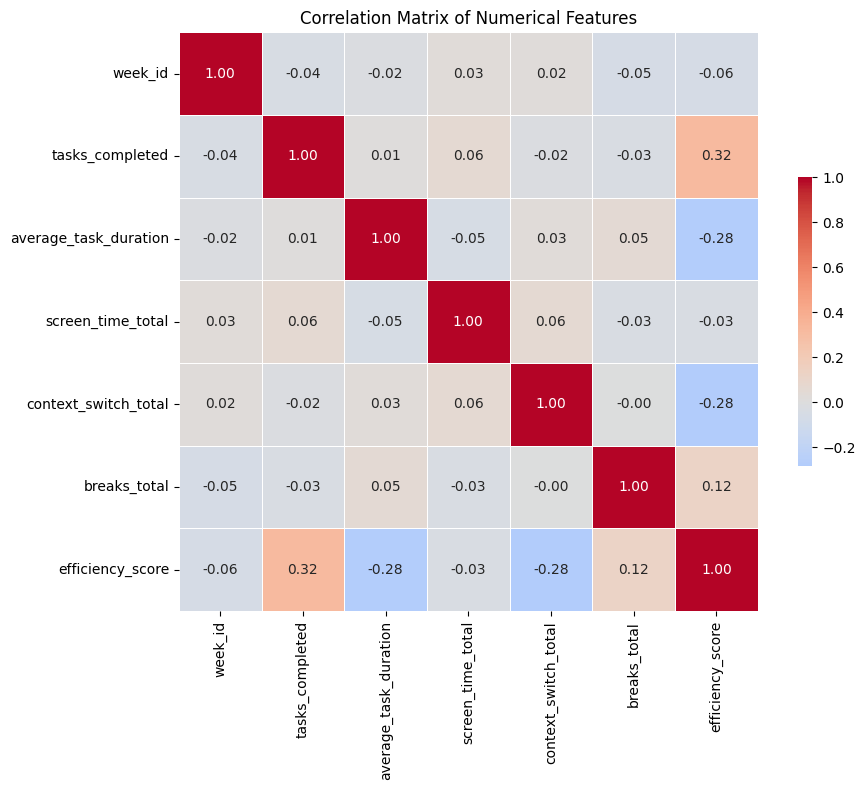

In [7]:
# Plot efficiency score distribution
plt.figure(figsize=(10, 6))
sns.histplot(weekly_df['efficiency_score'], bins=20, kde=True)
plt.title('Distribution of Employee Efficiency Scores')
plt.xlabel('Efficiency Score (0-100)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Plot productivity label distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=weekly_df, x='productivity_label',
              order=['At Risk', 'Average', 'Highly Effective'])
plt.title('Distribution of Productivity Labels')
plt.xlabel('Productivity Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Correlation heatmap
# Select only numeric features
numerical_features = weekly_df.select_dtypes(include='number').columns
corr_matrix = weekly_df[numerical_features].corr()

# Replace NaN with 0 to avoid plotting errors
corr_matrix = corr_matrix.fillna(0)

# Print for debugging
print("Correlation matrix:\n", corr_matrix)
print("Numerical features:\n", list(numerical_features))

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True,
            linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

In [8]:
def predict_employee_productivity(input_data, variation_factor=0.1):
    input_df = pd.DataFrame([input_data])

    # Base predictions with variation
    base_score = reg_pipeline.predict(input_df)[0]
    varied_score = max(0, min(100, round(base_score * (1 + random.uniform(-variation_factor, variation_factor)), 2)))
    label = clf_pipeline.predict(input_df)[0]

    # Dynamic suggestions
    suggestion_pools = {
        'time': [
            "Try Pomodoro technique (25min work/5min break)",
            "Block focus time in calendar",
            "Prioritize with Eisenhower Matrix"
        ],
        'health': [
            "Take 5-min walk every 90 minutes",
            "Adjust workspace lighting",
            "Practice mindfulness between tasks"
        ],
        'collab': [
            "Shorter frequent check-ins",
            "Use collaborative docs",
            "Set meeting agendas"
        ]
    }
    suggestions = [random.choice(pool) for pool in suggestion_pools.values()]

    # Randomized insights
    positive = [
        f"Productivity peaks on {random.choice(['Mon', 'Wed', 'Fri'])}",
        f"{random.choice(['Mornings', 'Afternoons'])} are most effective"
    ]
    negative = [
        f"Productivity drops after {random.randint(3,6)}hrs continuous work",
        f"Context switching increases time by {random.randint(15,40)}%"
    ]

    # Task recommendations
    tasks = random.sample([
        "Complete progress report",
        "Schedule 1:1 meetings",
        "Review backlog",
        "Update documentation",
        "Prepare presentation"
    ], 3)

    return {
        'efficiency_score': varied_score,
        'productivity_label': label,
        'suggestions': suggestions,
        'positive_insights': positive,
        'negative_insights': negative,
        'recommended_tasks': tasks
    }

In [9]:
test_input = {
    'avg_estimated_time': 3.5,
    'total_estimated_time': 28.0,
    'avg_actual_time': 3.8,
    'total_actual_time': 30.4,
    'completion_rate': 0.75,
    'high_priority_ratio': 0.4,
    'morning_task_ratio': 0.6,
    'unique_categories': 5,
    'screen_time_minutes': 320,
    'breaks_taken': 3,
    'context_switches': 18,
    'meeting_hours': 8.5,
    'noise_level': 'Medium',
    'collaboration_sessions': 3,
    'light_environment': 'Moderate'
}

for i in range(1):
    print(f"\n=== Prediction {i+1} ===")
    result = predict_employee_productivity(test_input)
    for k, v in result.items():
        print(f"\n{k}:\n" + "\n".join([f"- {x}" for x in (v if isinstance(v, list) else [v])]))


=== Prediction 1 ===

efficiency_score:
- 72.0199966430664

productivity_label:
- Average

suggestions:
- Block focus time in calendar
- Take 5-min walk every 90 minutes
- Use collaborative docs

positive_insights:
- Productivity peaks on Fri
- Mornings are most effective

negative_insights:
- Productivity drops after 5hrs continuous work
- Context switching increases time by 27%

recommended_tasks:
- Schedule 1:1 meetings
- Update documentation
- Review backlog


In [ ]:
import joblib

# Save models
joblib.dump(reg_pipeline, 'efficiency_score_regressor.pkl')
joblib.dump(clf_pipeline, 'productivity_classifier.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

# Download files (for deployment)
from google.colab import files
files.download('efficiency_score_regressor.pkl')
files.download('productivity_classifier.pkl')
files.download('preprocessor.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>